In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.6 MB/s eta 0:00:00


In [ ]:
# import libraries
import os
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import contractions
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from transformers import pipeline
from transformers import AutoTokenizer
from datasets import Dataset
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load from Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NLPProject/Dataset/twitter_training.csv', header=None, names=['tweet_id', 'entity', 'sentiment', 'tweet'])
val_df = pd.read_csv('/content/drive/MyDrive/NLPProject/Dataset/twitter_validation.csv', header=None, names=['tweet_id', 'entity', 'sentiment', 'tweet'])

In [ ]:
# Combine dataset
df = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
# Data exploration
print("Dataset Shape:", df.shape)
print("")
print("Column Infomation:\n", df.info())
print("")
print("Sample Data:\n", df.head())
print("")
print("Unique Entities (Brands):", df['entity'].unique())
print("")
print("Sentiment Distribution:\n", df['sentiment'].value_counts())

Dataset Shape: (75682, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   75682 non-null  int64 
 1   entity     75682 non-null  object
 2   sentiment  75682 non-null  object
 3   tweet      74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
Column Infomation:
 None

Sample Data:
    tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                               tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i 

In [ ]:
# Handle missing values
df.dropna(subset=['tweet'], inplace=True)
print("Missing Values after Drop:\n", df.isnull().sum())

# Filter out Irrelevant sentiments
df = df[df['sentiment'] != 'Irrelevant']

Missing Values after Drop:
 tweet_id     0
entity       0
sentiment    0
tweet        0
dtype: int64


In [ ]:
# Sample test brands for monitoring
brand = 'Google'
brand_df = df[df['entity'] == brand].copy()
print(f"Tweets for {brand}: {len(brand_df)}")

brand_2 = 'Amazon'
brand_2_df = df[df['entity'] == brand_2].copy()
print(f"Tweets for {brand_2}: {len(brand_2_df)}")

Tweets for Google: 1778
Tweets for Amazon: 2121


# Data Preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
  if pd.isna(text):
    return ""

  text = contractions.fix(text)

  # Remove URLs, mentions, hashtags, punctuation/emojis
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'@\w+|#\w+', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  # Lowercase
  text = text.lower()

  # Tokenization
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english')).union({'rt', 'via', 'amp'})

  # Negation preservation
  processed_tokens = []
  for i in range(len(tokens)):
    if tokens[i] == 'not' and i + 1 < len(tokens):
      processed_tokens.append('not_' + tokens[i + 1])
      i += 1
    else:
      processed_tokens.append(tokens[i])

  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return ' '.join(tokens)

In [ ]:
# Apply preprocessing to the full dataset and tweet feature
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
brand_df['cleaned_tweet'] = brand_df['tweet'].apply(preprocess_text)

In [ ]:
# Sample test cleaned data
print("Raw Tweet:", df['tweet'].iloc[25])
print("Cleaned Tweet:", df['cleaned_tweet'].iloc[25])

Raw Tweet: The biggest disappointment of my life came a year ago.
Cleaned Tweet: biggest disappointment life came year ago


# Exploratory Data Analysis (EDA)

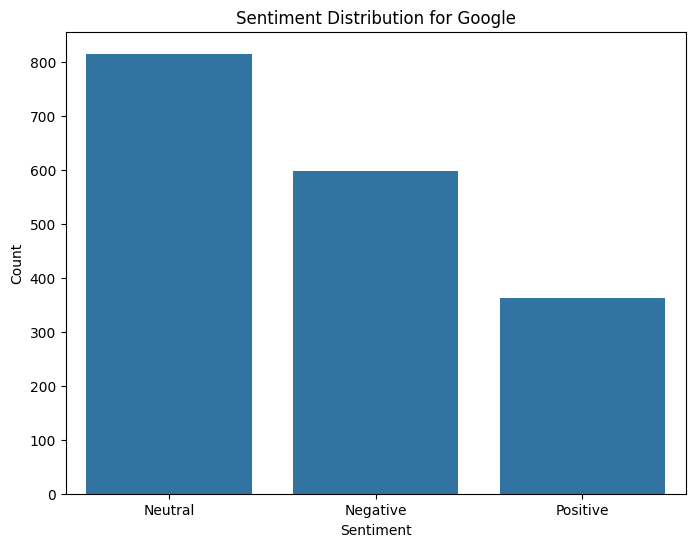

In [ ]:
# Sentiment distribution for the brand
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=brand_df)
plt.title(f'Sentiment Distribution for {brand}')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<Figure size 1200x600 with 0 Axes>

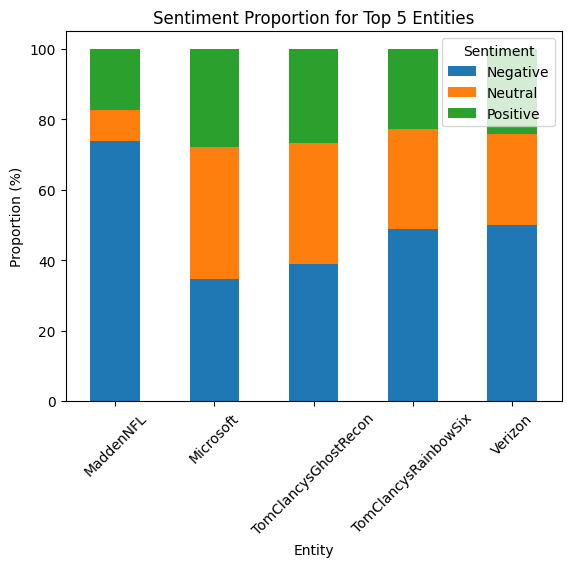

In [ ]:
top_entities = df['entity'].value_counts().head(5).index
sentiment_by_top_entities = df[df['entity'].isin(top_entities)].groupby('entity')['sentiment'].value_counts(normalize=True).unstack().fillna(0) * 100

plt.figure(figsize=(12, 6))
sentiment_by_top_entities.plot(kind='bar', stacked=True)
plt.title(f'Sentiment Proportion for Top 5 Entities')
plt.xlabel('Entity')
plt.ylabel('Proportion (%)')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

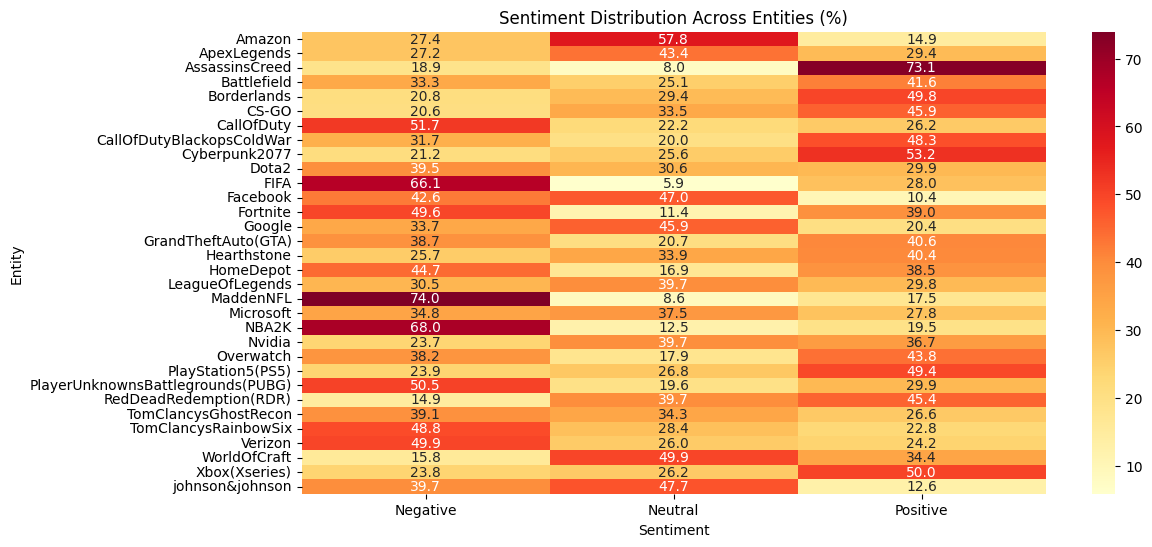

In [ ]:
# Cross tabulation of sentiment by entity
sentiment_by_entity = pd.crosstab(df['entity'], df['sentiment'], normalize='index') * 100
plt.figure(figsize=(12, 6))
sns.heatmap(sentiment_by_entity, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Sentiment Distribution Across Entities (%)')
plt.xlabel('Sentiment')
plt.ylabel('Entity')
plt.show()

# Model Preparation

In [ ]:
# Map sentiments to binary labels
label_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['label'] = df['sentiment'].map(label_map)
brand_df['label'] = brand_df['sentiment'].map(label_map)

In [ ]:
# Load tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
  return tokenizer(examples['cleaned_tweet'], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset
full_dataset = Dataset.from_pandas(df[['cleaned_tweet', 'label']])
brand_dataset = Dataset.from_pandas(brand_df[['cleaned_tweet', 'label']])

# Apply tokenization
full_dataset = full_dataset.map(tokenize_function, batched=True)
brand_dataset = brand_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
full_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
brand_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/61949 [00:00<?, ? examples/s]

Map:   0%|          | 0/1778 [00:00<?, ? examples/s]

# Load Model

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Split full dataset for train/eval
train_test_split = full_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Training arguments
training_args = TrainingArguments(
  output_dir='./results',
  num_train_epochs=6,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  warmup_steps=500,
  weight_decay=0.01,
  logging_dir='./logs',
  logging_steps=10,
  eval_strategy="epoch",
  save_strategy="epoch",
  load_best_model_at_end=True,
  report_to=[]
)

# Trainer
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
)

# Finetune
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.540300,0.470663
2,0.486000,0.391847
3,0.136900,0.373054
4,0.056800,0.355949
5,0.064300,0.357180
6,0.032600,0.377155


TrainOutput(global_step=18588, training_loss=0.2694421512609522, metrics={'train_runtime': 3191.6468, 'train_samples_per_second': 93.166, 'train_steps_per_second': 5.824, 'total_flos': 1.955945680377293e+16, 'train_loss': 0.2694421512609522, 'epoch': 6.0})

<Figure size 800x600 with 0 Axes>

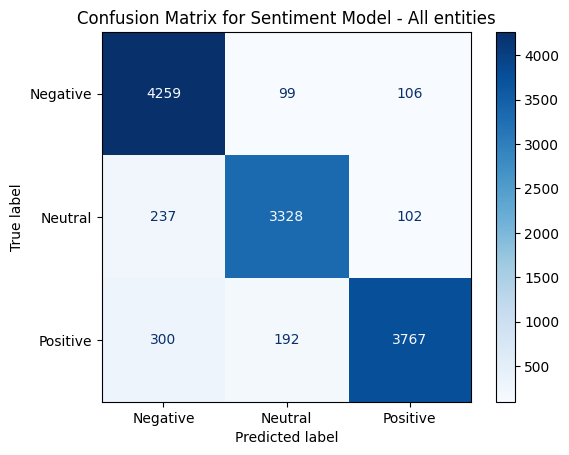

In [ ]:
# Get predictions
predictions = trainer.predict(eval_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# confusion matrix
cm = confusion_matrix(labels, preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Sentiment Model - All entities')
plt.show()

In [ ]:
# Classification report
report = classification_report(labels, preds, target_names=['Negative', 'Neutral', 'Positive'])
print(f'Classification Report for Sentiment Model (All Entities):\n{report}')

Classification Report for Sentiment Model (All Entities):
              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92      4464
     Neutral       0.92      0.91      0.91      3667
    Positive       0.95      0.88      0.91      4259

    accuracy                           0.92     12390
   macro avg       0.92      0.92      0.92     12390
weighted avg       0.92      0.92      0.92     12390



<Figure size 800x600 with 0 Axes>

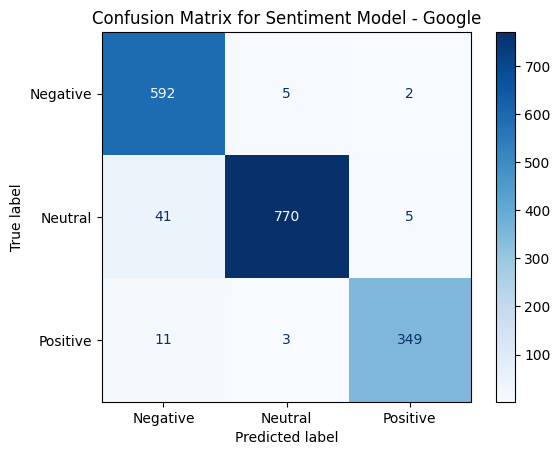


Classification Report for Sentiment Model - Google:
              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95       599
     Neutral       0.99      0.94      0.97       816
    Positive       0.98      0.96      0.97       363

    accuracy                           0.96      1778
   macro avg       0.96      0.96      0.96      1778
weighted avg       0.96      0.96      0.96      1778



In [ ]:
# Get predictions
predictions = trainer.predict(brand_dataset)
preds = predictions.predictions.argmax(-1)
brand_labels = brand_dataset.to_pandas()['label'].to_list()

# confusion matrix
cm = confusion_matrix(brand_labels, preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Sentiment Model - {brand}')
plt.show()
print("")

# Classification report
report = classification_report(brand_labels, preds, target_names=['Negative', 'Neutral', 'Positive'])
print(f'Classification Report for Sentiment Model - {brand}:\n{report}')

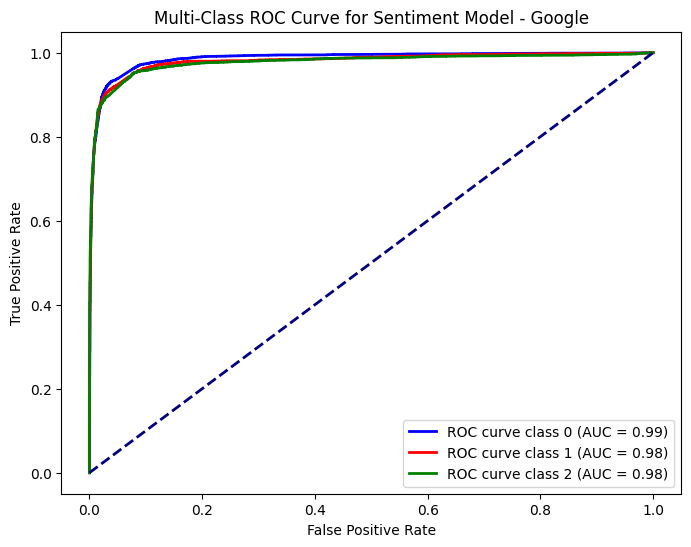

In [ ]:
predictions = trainer.predict(eval_dataset)
preds = predictions.predictions
labels = label_binarize(predictions.label_ids, classes=[0, 1, 2])

# ROC curve and ROC area for each class - Google
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(f'Multi-Class ROC Curve for Sentiment Model - {brand}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

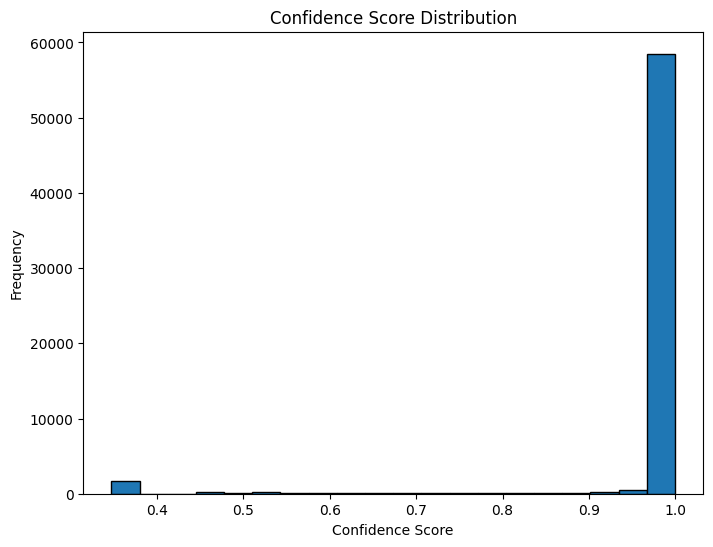

In [ ]:
# Confidence Score distribution
plt.figure(figsize=(8, 6))
plt.hist(df['confidence'], bins=20, edgecolor='black')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

# Inferencing

In [ ]:
best_model_path = trainer.state.best_model_checkpoint
print(f"Best model checkpoint: {best_model_path}")

Best model checkpoint: ./results/checkpoint-12392


In [ ]:
# Load the best fine tuned model
model = AutoModelForSequenceClassification.from_pretrained(best_model_path)

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create a pipeline with the fine tuned model
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Predict on brand dataset
brand_df['predicted_sentiment'] = brand_df['cleaned_tweet'].apply(lambda x: classifier(x[:128])[0]['label'].replace('LABEL_', ''))

# Custom tweet predictions
custom_tweets = [
  "I love the new features in Apple's latest iPhone!",
  "Terrible customer service from Apple, never buying again.",
  "The Apple event was okay, nothing special.",
  "Google’s new AI tool is a game-changer, absolutely brilliant!",
  "Apple’s iOS update crashed my phone, what a disaster.",
  "Apple’s event today was just a rehash of old ideas, meh.",
  "Sarcasm aside, Apple’s latest product is actually pretty good lol.",
  "Apple support was useless, couldn’t fix my iPad issue.",
  "Google Maps failed me again, lost for an hour thanks to this junk."
]


print("\nCustom Tweet Predictions (Fine-Tuned Twitter-RoBERTa, 2=Positive, 1=Neutral, 0=Negative):")
print("*****************************************************************************************")
print("")

for tweet in custom_tweets:
  cleaned_tweet = preprocess_text(tweet)
  prediction = classifier(cleaned_tweet[:128])[0]
  label = prediction['label'].replace('LABEL_', '')
  confidence = prediction['score']
  print(f"Tweet: {tweet}")
  print(f"Predicted Sentiment: {label} (Confidence: {confidence:.2f})")
  print("-" * 50)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Custom Tweet Predictions (Fine-Tuned Twitter-RoBERTa, 2=Positive, 1=Neutral, 0=Negative):
*****************************************************************************************

Tweet: I love the new features in Apple's latest iPhone!
Predicted Sentiment: 2 (Confidence: 1.00)
--------------------------------------------------
Tweet: Terrible customer service from Apple, never buying again.
Predicted Sentiment: 0 (Confidence: 1.00)
--------------------------------------------------
Tweet: The Apple event was okay, nothing special.
Predicted Sentiment: 1 (Confidence: 1.00)
--------------------------------------------------
Tweet: Google’s new AI tool is a game-changer, absolutely brilliant!
Predicted Sentiment: 2 (Confidence: 1.00)
--------------------------------------------------
Tweet: Apple’s iOS update crashed my phone, what a disaster.
Predicted Sentiment: 0 (Confidence: 1.00)
--------------------------------------------------
Tweet: Apple’s event today was just a rehash of old